In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
from preprocess import contractions

In [2]:
train = pd.DataFrame(pd.read_excel("./Dataset/Constraint_English_Train.xlsx",engine='openpyxl'))
test = pd.DataFrame(pd.read_excel("./Dataset/Constraint_English_Val.xlsx",engine='openpyxl'))
print("Train shape:",train.shape)
print("Test shape:",test.shape)

Train shape: (6420, 3)
Test shape: (2140, 3)


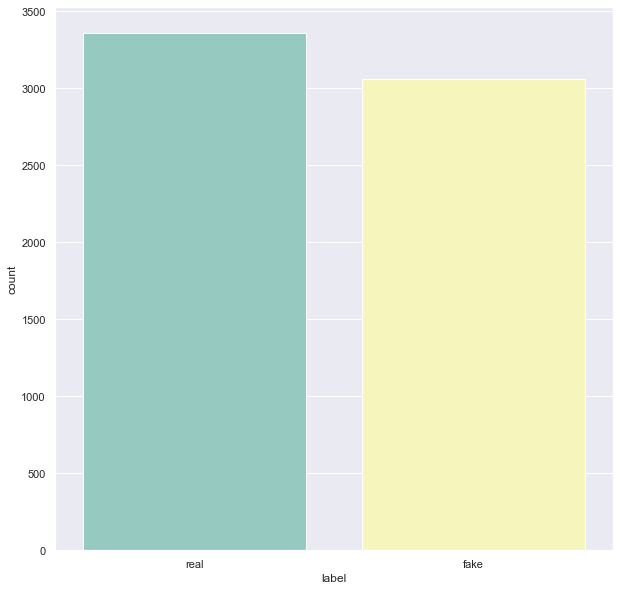

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize']=[10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.countplot(x='label', data=train, palette='Set3')
plt.show()

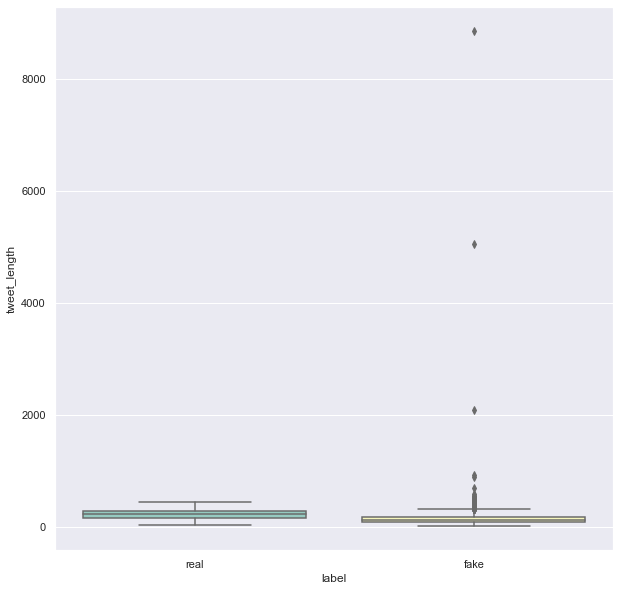

In [4]:
train["tweet_length"]=train['tweet'].apply(lambda x: len(x))
sns.boxplot(y="tweet_length",x='label',data=train,palette="Set3")
plt.show()

train["tweet"]=train['tweet'].str.strip()
print(len(train[train["tweet"]==0]))

In [5]:
def preprocess_text(x):
    cleaned_text=re.sub(r"http\S+", '',x, flags=re.MULTILINE)
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', cleaned_text)
    #cleaned_text=x
    word_list = []
    for each_word in cleaned_text.split():
        try:
            word_list.append(contractions.fix(each_word.lower()).lower())
        except:
            print(x)
    return " ".join(word_list)

train["tweet"]=train["tweet"].apply(lambda x:preprocess_text(x))
test["tweet"]=test["tweet"].apply(lambda x:preprocess_text(x))



st="States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux Elon Musck To New Baby; Get A Job Kid! https://t.co/bc8Re0Ai3Y #christmas #covid19 #elonmusk #achristmascarol"
print(re.sub(r"http\S+", '',st,flags=re.MULTILINE))
print(re.sub(r'[^a-zA-Z\d\s\']+', '', st))



In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

train['tweet']=train["tweet"].apply(lambda x: word_tokenize(x))
train["tweet"]=train["tweet"].apply(lambda x: [each_word for each_word in x if each_word not in stopwords.words('english')])

test['tweet']=test["tweet"].apply(lambda x: word_tokenize(x))
test["tweet"]=test["tweet"].apply(lambda x: [each_word for each_word in x if each_word not in stopwords.words('english')])

In [7]:
train["tweet"]=train["tweet"].apply(lambda x: " ".join(x))
test["tweet"]=test["tweet"].apply(lambda x: " ".join(x))

In [8]:
all_text_real=" ".join(train[train['label']=='real']['tweet'])
all_text_fake=" ".join(train[train['label']=='fake']['tweet'])


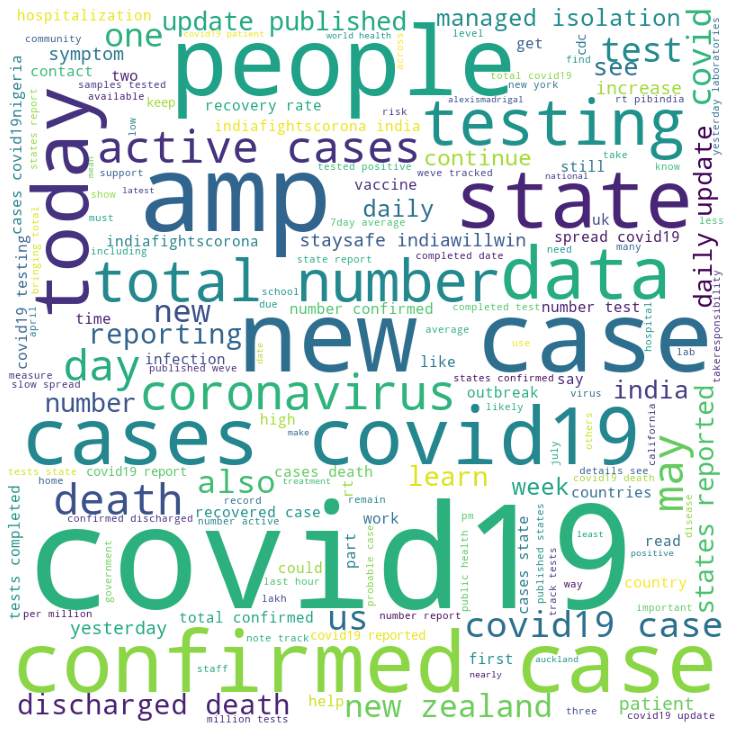

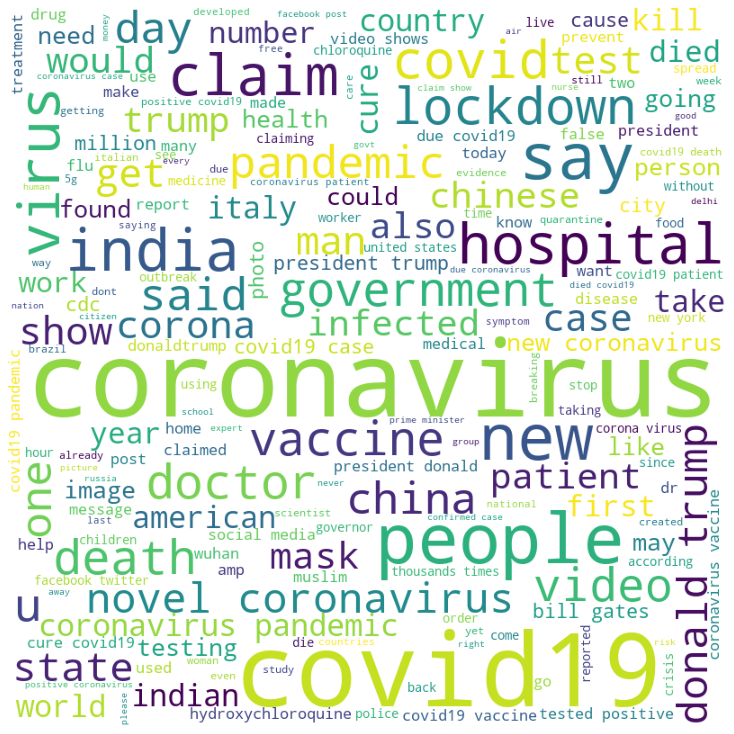

In [9]:
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import matplotlib.pyplot as plt
wordcloud=WordCloud(width=800,height=800,
                   background_color='white',
                   stopwords=stopwords.words('english'),
                   min_font_size=10).generate(all_text_real)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
wordcloud=WordCloud(width=800,height=800,
                   background_color='white',
                   stopwords=stopwords.words('english'),
                   min_font_size=10).generate(all_text_fake)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


count_vectorizer=CountVectorizer(ngram_range=(1,2))
tf_idf_transformer=TfidfTransformer(smooth_idf=False)

count_vectorizer.fit(train["tweet"].values)
count_vect_train=count_vectorizer.transform(train['tweet'].values)

tf_idf_transformer.fit(count_vect_train)
tf_idf_train=tf_idf_transformer.transform(count_vect_train)

count_vect_test=count_vectorizer.transform(test['tweet'].values)
tf_idf_test=tf_idf_transformer.transform(count_vect_test)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
import time

In [11]:
tfidf=TfidfVectorizer(stop_words="english",max_df=0.7)
tf_idf_train=tfidf.fit_transform(train["tweet"].values)
tf_idf_test=tfidf.transform(test["tweet"].values)

from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
tf_idf_train=scaler.fit_transform(tf_idf_train)
tf_idf_test=scaler.transform(tf_idf_test)

In [12]:
train = train.replace(['fake', 'real'], [0, 1])
test = test.replace(['fake', 'real'], [0, 1])

variety_mappings = {1: 'real', 0: 'fake'}

X_train=tf_idf_train
y_train=train['label'].values
X_test=tf_idf_test
y_test=test['label'].values


df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training', 'Accuracy_Test', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs)'
])
models_trained_list=[]

def get_perf_metrics(model,i):
    model_name=type(model).__name__
    if(model_name=="SVC"):
        model_name+="("+model.kernel+")"
    start_time =time.time()
    print("Trainning {} model...".format(model_name))
    
    model.fit(X_train,y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [13]:
models_list=[LogisticRegression(),
             SVC(kernel="linear"),
             SVC(kernel='sigmoid'),
             SVC(kernel='rbf'),
             MultinomialNB(),
             KNeighborsClassifier(n_neighbors=15),
             RandomForestClassifier(n_estimators=1000, random_state=0),
             DecisionTreeClassifier(),
            ]
for n,model in enumerate(models_list):
    get_perf_metrics(model,n)

Trainning LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.10 s.
Completed LogisticRegression model's performance assessment.
Trainning SVC(linear) model...
Completed SVC(linear) model training.
Time elapsed: 2.76 s.
Completed SVC(linear) model's performance assessment.
Trainning SVC(sigmoid) model...
Completed SVC(sigmoid) model training.
Time elapsed: 2.65 s.
Completed SVC(sigmoid) model's performance assessment.
Trainning SVC(rbf) model...
Completed SVC(rbf) model training.
Time elapsed: 4.95 s.
Completed SVC(rbf) model's performance assessment.
Trainning MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.00 s.
Completed MultinomialNB model's performance assessment.
Trainning KNeighborsClassifier model...
Completed KNeighborsClassifier model training.
Time elapsed: 0.00 s.
Completed KNeighborsClassifier model's performance assessment.
Trainning RandomForestClassifier model...
Completed RandomForestClassifier model t

In [14]:
df_perf_metrics

,Model,Accuracy_Training,Accuracy_Test,Precision,Recall,f1_score,Training Time (secs)
0,LogisticRegression,0.958879,0.911215,0.918165,0.911607,0.914875,0.10
1,SVC(linear),0.987850,0.923832,0.929148,0.925000,0.927069,2.76
2,SVC(sigmoid),0.971651,0.922430,0.928957,0.922321,0.925627,2.65
3,SVC(rbf),0.996573,0.923364,0.934545,0.917857,0.926126,4.95
4,MultinomialNB,0.955763,0.910280,0.891231,0.943750,0.916739,0.00
5,KNeighborsClassifier,0.910592,0.900467,0.898857,0.912500,0.905627,0.00
6,RandomForestClassifier,1.000000,0.899533,0.921715,0.883036,0.901961,32.02
7,DecisionTreeClassifier,1.000000,0.828037,0.827526,0.848214,0.837743,0.81


In [25]:
real_test=pd.read_csv("./Dataset/covid19_tweets.csv")
print(real_test['text'].values)

['If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0'
 "Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu"
 '@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3'
 ...
 "@CTVNews A powerful painting by Juan Lucena. It's a tribute to the grandparents who died of COVID 19 and the grandc… https://t.co/wnXbbyoCe2"
 'More than 1,200 students test positive for #COVID19 at major university - ABC News https://t.co/6aNhSiF5gh'
 'I stop when I see a Stop\n\n@SABCNews\n@IzindabaNews24\n@dailysunsa\n@eNCA\n@AliwalNorth\n@Ambitiouz_Ent\n@Official_SABC1… https://t.co/ReG8pwZoN7']


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
print(scaler.fit_transform(tf_idf_train))

In [26]:
from sklearn.model_selection import GridSearchCV

model=SVC(kernel='rbf')

#Best params 1 {'C':10,'max_iter':1000}
#Best params 2 {'C':8,'max_iter':1200} Acc:0.9275
#Best param 3 {'C':3, 'max_iter':1400} Acc:0.9303

max_iter=[800,1000,1400] 
C = [3]

param_grid = dict(max_iter=max_iter,C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)
print('Best params: ', grid_result.best_params_)

model = grid_result.best_estimator_


y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END ..................................C=3, max_iter=800; total time=  12.3s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END ..................................C=3, max_iter=800; total time=   1.5s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END ..................................C=3, max_iter=800; total time=   1.3s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END ..................................C=3, max_iter=800; total time=   1.3s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END ..................................C=3, max_iter=800; total time=   1.5s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1000; total time=   2.0s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1000; total time=   1.7s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1000; total time=   1.9s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1000; total time=   1.7s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1000; total time=   1.6s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1400; total time=   2.5s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1400; total time=   2.2s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1400; total time=   2.4s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1400; total time=   1.9s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] END .................................C=3, max_iter=1400; total time=   2.0s


D:\Users\abc23\anaconda3\envs\vader\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best params:  {'C': 3, 'max_iter': 1400}
Accuracy:  0.9299065420560748
Precision:  0.9353680430879713
Recall:  0.9303571428571429
f1-score:  0.9328558639212176


import re, string, unicodedata
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions_fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    if words not in stopwords.words('english'):
        return words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
def join(word):
    return "".join(word)
def normalize(words):
    word_list=[]
    for word in words.split():
        #word = join(remove_non_ascii(word))
        print('#:',word)
        word = join(to_lowercase(word))
        print('##:',word)
        #word = join(remove_punctuation(word))
        print('###:',word)
        #word = replace_numbers("".join(word))
        word = remove_stopwords(word)
        print('####:',word)
        word_list.append(word)
 
    word_list=list(filter(None,word_list))
    return " ".join(word_list)

if __name__ == "__main__":
    sample = "States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux Elon Musck To New Baby; Get A Job Kid! https://t.co/bc8Re0Ai3Y #christmas #covid19 #elonmusk #achristmascarol"            
    
    sample = remove_URL(sample)
    


    # Tokenize
    #words = nltk.word_tokenize(sample)
    #print(words)

    # Normalize
    words = normalize(sample)
    #print(words)

print(words)
print(preprocess_text(sample))

from preprocess import contractions
print(contractions.fix("I'm"))

from sklearn.preprocessing import MaxAbsScaler
data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
scaler = MaxAbsScaler()
print(tf_idf_train)
#print(scaler.fit_transform(tf_idf_train))